In [1]:
import requests as rq
import os
import pandas as pd
from bs4 import BeautifulSoup as bbs
import matplotlib.pyplot as plt

In [2]:
def data_extract():
    baseurl = 'http://www.kuet.ac.bd/index.php/welcome/studentlist'
    os.makedirs('data',exist_ok=True)
    try:
        res = rq.get(baseurl)
        page = bbs(res.text, 'html.parser')
        data = {}
        for i in page.findAll('tr')[2:]:
            val = [j.text for j in i.findAll('td')]
            try:
                int(val[1])
            except:
                val = val[1:]
            if val[3] == '0':
                continue
            elif len(val) != 8:
                start = 0
                for k in range(len(val)//8):
                    val1 = val[start:start+8]
                    val1[1] = val1[1].replace(
                        '\u202c', '').replace('\u202d', '')
                    val1[2] = val1[2].replace(
                        '\u202c', '').replace('\u202d', '')
                    val1[1:3] = map(int, val1[1:3])
                    data[val1[0]] = {}
                    data[val1[0]]['male'] = val1[1]
                    data[val1[0]]['female'] = val1[2]
                    name = val[0].split()
                    data[val[0]]['short'] = name[2] if name[0] == 'Department' else name[0]
                    start = (k+1)*8
            else:
                val[1] = val[1].replace('\u202c', '').replace('\u202d', '')
                val[2] = val[2].replace('\u202c', '').replace('\u202d', '')
                val[1:3] = map(int, val[1:3])
                data[val[0]] = {}
                data[val[0]]['male'] = val[1]
                data[val[0]]['female'] = val[2]
                name = val[0].split()
                data[val[0]]['short'] = name[2] if name[0] == 'Department' else name[0]
        del data['Grand Total']
        try:
            val = page.findAll('p')[-1].text
            time_val = '('+' '.join(val.split(' ')[2:])+')'
        except:
            time_val = ""
        df = pd.DataFrame([], columns=['ac_male', 'ac_female', 'short', 'time'])
        for i in data.keys():
            df.loc[i] = list(data[i].values())+[time_val]
        df['department'] = list(data.keys())
        df['d_male'] = df['ac_male']/(df['ac_male']+df['ac_female'])
        df['d_female'] = df['ac_female']/(df['ac_male']+df['ac_female'])
        df['v_male'] = df['ac_male']/df['ac_male'].sum()
        df['v_female'] = df['ac_female']/df['ac_female'].sum()
        df.to_csv('data/Last Updated.csv',index=False)
    except:
        df =pd.read_csv('data/Last Updated.csv',index_col='department')
    return df

In [3]:
def data_plot(data, wise='Department', save=True):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)
    os.makedirs('Images',exist_ok=True)
    
    if wise == 'Department':
        data = data.sort_values(by=['d_female'], ascending=False)
        male = data['d_male']
        female = data['d_female']
    else:
        data = data.sort_values(by=['v_female'], ascending=False)
        female = data['v_female']

    short = data['short']

    if wise == 'Department':
        plt.bar(short, male, bottom=female, color='limegreen',
                edgecolor='white', label='Boys')
        title = 'Percentage of Boys & Girls Department wise in KUET {}'.format(
            data['time'][0])
        ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    else:
        for i, j in enumerate(female):
            ax.text(i, j, '{:.2f}%'.format(100*j),
                    ha='center', va='bottom', fontsize=15)
        ax.set_yticklabels([])
        title = 'Girls in KUET {}'.format(data['time'][0])

    plt.bar(short, female, color='tomato', edgecolor='white', label='Girls')

    plt.xlabel("Department Name", fontsize=25)
    plt.ylabel('Student Number in Percentage', fontsize=25)
    plt.title(title, fontsize=25)

    xtickNames = ax.set_xticklabels(short)

    ax.legend(fontsize=30)
    plt.setp(xtickNames, rotation=30, fontsize=15)
    if save:
        plt.savefig('Images/'+title+'.png')
    plt.show()

In [4]:
df = data_extract()

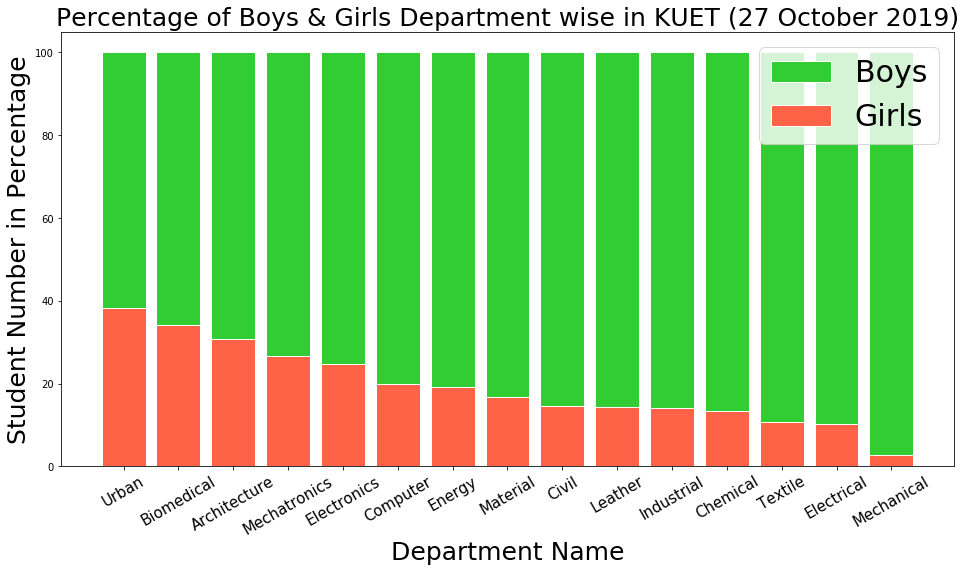

In [5]:
data_plot(df)

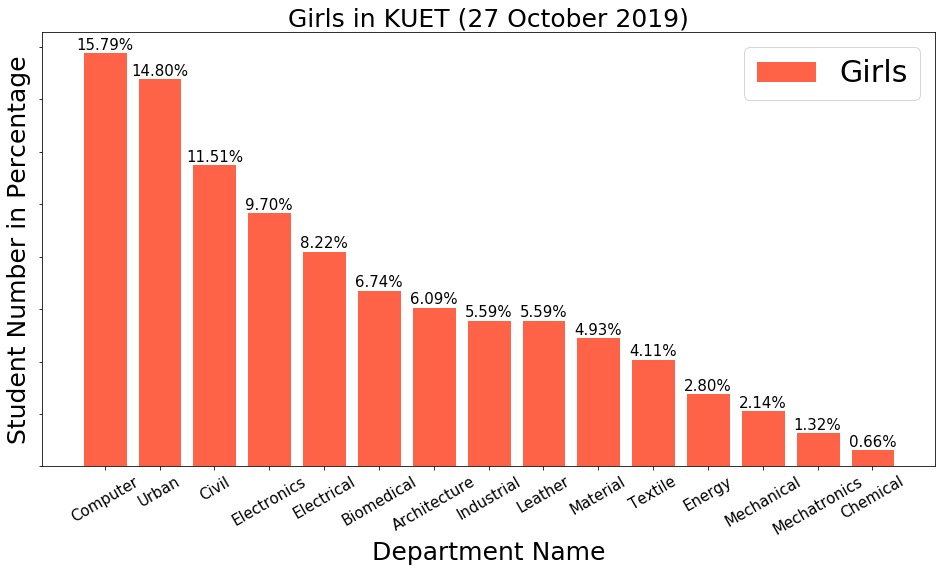

In [6]:
data_plot(df, wise='Versity')